In [1]:
import pandas as pd
from pathlib import Path

# Load the data
nfl_data_path = Path("nfl_combined_2023&2022.csv")
nfl_data = pd.read_csv(nfl_data_path, delimiter='\t')

# Inspect the first few rows of the DataFrame
print(nfl_data.head())

             name   qbr   paa  plays   epa  pass  run  sack  pen   raw  \
0  Baker Mayfield  51.9   4.9    511  47.4  40.4  3.6  -9.2  3.4  53.4   
1      Derek Carr  47.7  -1.2    459  37.6  42.9 -5.2  -9.9 -0.1  49.1   
2     Davis Mills  35.0 -23.3    573  24.8  23.1 -1.2 -12.7  2.9  36.0   
3    Dak Prescott  59.9  16.7    480  56.6  48.5  5.3  -8.3  2.7  62.0   
4      Jared Goff  60.3  15.4    489  50.2  49.0 -1.0  -7.2  2.3  60.9   

   Average Salary  
0        37955071  
1        35150681  
2        15000000  
3       121500000  
4       160000000  


In [2]:
# Check for missing values
print(nfl_data.isnull().sum())

# Selecting features and the target variable
X = nfl_data.drop(['name', 'Average Salary'], axis=1)  # Drop non-numeric and target variable
y = nfl_data['Average Salary']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

name              0
qbr               0
paa               0
plays             0
epa               0
pass              0
run               0
sack              0
pen               0
raw               0
Average Salary    0
dtype: int64


RandomForest

In [3]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
regressor = RandomForestRegressor(random_state=42)

# Train the model
regressor.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred = regressor.predict(X_test_scaled)

# Calculate the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 7023308725352305.0
R^2 Score: 0.7052068374728309


RMSE is less sensitive to outliers compared to MSE because the square root reduces the impact of large errors.

In [5]:
import numpy as np

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 83805183.16519752


Feature Importances Chart

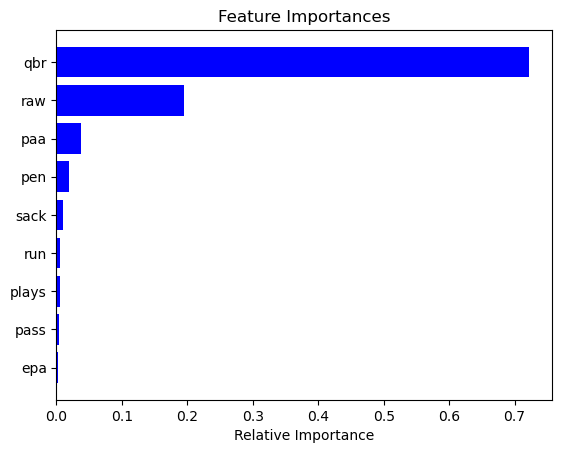

In [6]:
import matplotlib.pyplot as plt

feature_importances = regressor.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Random Forest Contd. - Hyperparameter Tuning

In [7]:
from sklearn.model_selection import GridSearchCV

# Define parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print(grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}


In [8]:
# Rebuild the model with the best parameters
best_regressor = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_regressor.fit(X_train_scaled, y_train)

# Make predictions with the optimized model
y_pred_optimized = best_regressor.predict(X_test_scaled)

# Evaluate the optimized model
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
rmse_optimized = np.sqrt(mse_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

print(f"Optimized Mean Squared Error: {mse_optimized}")
print(f"Optimized Root Mean Squared Error: {rmse_optimized}")
print(f"Optimized R^2 Score: {r2_optimized}")

Optimized Mean Squared Error: 6971152947546529.0
Optimized Root Mean Squared Error: 83493430.56520392
Optimized R^2 Score: 0.7073960003424522


Cross-Validation

In [9]:
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores = cross_val_score(best_regressor, X_train_scaled, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-validation scores: [0.72429159 0.69531099 0.85134863 0.89644645 0.85343157]
Mean CV Score: 0.8041658458014883


In [10]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_regressor, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
cv_rmse_scores = np.sqrt(-cv_scores)
print("Cross-validation RMSE Salary:", cv_rmse_scores)
print("Mean CV RMSE Salary:", np.mean(cv_rmse_scores))

Cross-validation RMSE Salary: [36985163.53771878 43716736.63325522 36023697.69896435 33873298.68780559
 28257091.69677117]
Mean CV RMSE Salary: 35771197.650903024


Evaluating Model Using Trained Data

In [11]:
# Evaluate the model on the training set
y_train_pred = best_regressor.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Training Root Mean Squared Error: {rmse_train}")
print(f"Training R^2 Score: {r2_train}")

Training Mean Squared Error: 152629295374740.22
Training Root Mean Squared Error: 12354322.942789711
Training R^2 Score: 0.9801896866064169


Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Train the model
linear_regressor.fit(X_train_scaled, y_train)

LinearRegression()

In [14]:
# Predict on the test set
y_pred_linear = linear_regressor.predict(X_test_scaled)

# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression Mean Squared Error: {mse_linear}")
print(f"Linear Regression Root Mean Squared Error: {rmse_linear}")
print(f"Linear Regression R^2 Score: {r2_linear}")

Linear Regression Mean Squared Error: 7553289895101949.0
Linear Regression Root Mean Squared Error: 86909665.14204246
Linear Regression R^2 Score: 0.6829616491691501


In [15]:
### Print model coefficients
print(f"Coefficients: {linear_regressor.coef_}")
print(f"Intercept: {linear_regressor.intercept_}")

Coefficients: [ 2.17573169e+07  1.56931392e+07 -6.26789475e+07  3.44221289e+09
 -2.86589302e+09 -1.59372754e+09  8.30362897e+06 -1.98240199e+08
 -2.23102957e+07]
Intercept: 105054408.2916654


Linear Regression Chart

In [16]:
import hvplot.pandas
# Create a scatter plot of years_experience versus the salary information
salary_plot = nfl_data.hvplot.scatter(
    x="qbr",
    y="Average Salary",
    title="Average Salary relative to Player's QBR"
)
salary_plot

:Scatter   [qbr]   (Average Salary)

In [17]:
# Reformat data of the independent variable X as a single-column array
X = nfl_data["qbr"].values.reshape(-1, 1)

# Display sample data
X[:5]

array([[51.9],
       [47.7],
       [35. ],
       [59.9],
       [60.3]])

In [18]:
X.shape

(60, 1)

In [19]:
# Create an array for the dependent variable y
y = nfl_data["Average Salary"]

In [20]:
# Create a model with scikit-learn
model_predict = LinearRegression()

In [21]:
# Fit the data into the model
model_predict.fit(X, y)

LinearRegression()

In [22]:
# Display the slope
print(f"Model's slope: {model_predict.coef_}")

Model's slope: [7428887.47817796]


In [23]:
# Display the y-intercept
print(f"Model's y-intercept: {model_predict.intercept_}")

Model's y-intercept: -290927600.83517385


In [24]:
# Display the model's best fit line formula
print(f"Model's formula: y = {model_predict.intercept_} + {model_predict.coef_[0]}X")

Model's formula: y = -290927600.83517385 + 7428887.478177962X


In [57]:
# Display the formula to predict the salary for a QBR of 77
print(f"Model's formula: y = {model_predict.intercept_} + {model_predict.coef_[0]} * 77")

Model's formula: y = -290927600.83517385 + 7428887.478177962 * 77


In [58]:
# Predict the salary for a person with a QBR of 77
YTD_QBR = model_predict.intercept_ + model_predict.coef_[0] * 77

In [59]:
# Display the prediction
print(f"Predicted salary for a person with a QBR inputted above: ${YTD_QBR:.2f}")

Predicted salary for a person with a QBR inputted above: $281096734.98


In [28]:
# Make predictions using the X set
predicted_salary = model_predict.predict(X)

In [54]:
# Create a copy of the original data
df_salary_predicted = nfl_data.copy()

# Add a column with the predicted salary values
df_salary_predicted["salary_predicted"] = predicted_salary

# Display sample data
# df_salary_predicted["salary_predicted"] = df_salary_predicted["salary_predicted"].apply(lambda x: '%.0f' % x)
df_salary_predicted.head()

,name,qbr,paa,plays,epa,pass,run,sack,pen,raw,Average Salary,salary_predicted
0,Baker Mayfield,51.9,4.9,511,47.4,40.4,3.6,-9.2,3.4,53.4,37955071,9.463166e+07
1,Derek Carr,47.7,-1.2,459,37.6,42.9,-5.2,-9.9,-0.1,49.1,35150681,6.343033e+07
2,Davis Mills,35.0,-23.3,573,24.8,23.1,-1.2,-12.7,2.9,36.0,15000000,-3.091654e+07
3,Dak Prescott,59.9,16.7,480,56.6,48.5,5.3,-8.3,2.7,62.0,121500000,1.540628e+08
4,Jared Goff,60.3,15.4,489,50.2,49.0,-1.0,-7.2,2.3,60.9,160000000,1.570343e+08


In [55]:
# Create a line plot of years_experience versus the predicted salary values
best_fit_line = df_salary_predicted.hvplot.line(
    x = "qbr",
    y = "salary_predicted",
    color = "red"
)
best_fit_line

:Curve   [qbr]   (salary_predicted)

In [56]:
# Superpose the original data and the best fit line
salary_plot * best_fit_line

:Overlay
   .Scatter.I :Scatter   [qbr]   (Average Salary)
   .Curve.I   :Curve   [qbr]   (salary_predicted)

In [17]:
# Cross-validation
cv_scores_linear = cross_val_score(linear_regressor, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
cv_rmse_scores_linear = np.sqrt(-cv_scores_linear)
print("Linear Regression Cross-validation RMSE scores:", cv_rmse_scores_linear)
print("Linear Regression Mean CV RMSE Score:", np.mean(cv_rmse_scores_linear))

Linear Regression Cross-validation RMSE scores: [51589155.98395161 42792176.6021961  52726896.31063572 61683359.18834733
 43863546.81810905]
Linear Regression Mean CV RMSE Score: 50531026.98064796
